In [1]:
# Import libs
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt

In [ ]:
# Download Dataset
!gdown 1tsZ2a_KHg3yp1FHxArWgllCs_pgvWtXg

In [ ]:
# Unzip Datenset. Das hier sind Linux-Befehle, die auf Colab funktionieren. Bist du auf Windows musst du etwas anderes benutzen oder manuell unzippen.
!unzip ...

Der Befehl "unzip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "ls" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [77]:
def plot_results(imgs, labels=None):
    if labels is None:
        labels = [None for i in range(len(imgs))]
    plt.figure(figsize=(10, 10))
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis("off")

In [5]:
"""
Im folgenden lesen wir die Bild-Daten ein.

Die Bilder liegen als np.uint8 mit einer Range von 0-255 vor.
Die import_images_from_folder()-Funktion nimmt den Pfad zu einem Ordner mit Bildern und gibt eine Python-Liste mit numpy-arrays dieser Bilder zurück.
"""

def import_images_from_folder(folder_path):
    imgs = []
    for relative_img_path in os.listdir(folder_path):
        img = cv2.imread(folder_path + relative_img_path)
        if img is not None:
            imgs.append(img)
    print('Imported '+str(len(imgs))+' images.')
    return imgs

In [73]:
# Nun haben wir eine Liste 'cats' in der alle Katzenbilder liegen.
cats_imgs = import_images_from_folder("INSERT PATH TO CATS")

# Weil der Rechner auf dem ich das hier code wenig RAM (32 GB) hat und ich Gefahr laufe ihn später zu crashen arbeiten wir testweise mal nur mit 8000 Bildern.
cats_imgs = cats_imgs[:8000]

Imported 11748 images.


(375, 500, 3)
(281, 300, 3)
(500, 489, 3)
(500, 403, 3)
(150, 150, 3)
(360, 431, 3)
(375, 500, 3)
(471, 500, 3)
(375, 500, 3)


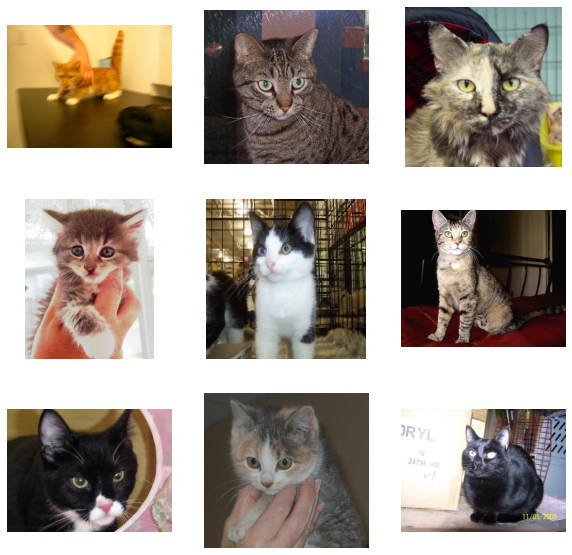

In [78]:
"""
Wie wir sehen haben die Katzenbilder unterschiedliche Bildauflösungen.
Unser Neural Network wird jedoch eine fixe quadratische Input-Size besitzen.
"""

plot_results(cats_imgs[:9])
for img in cats_imgs[:9]:
    print(img.shape)

In [9]:
"""
Aus Gründen der numerischen Stabilität (wenn intern im Netz viele Zahlen der Range 0-255 summiert und multipliziert werden können die Ergbenisse zu groß für den float32 Zahlenbereich werden),
macht es Sinn die Range -1.0 bis +1.0 zu nutzen. Außerdem benötigen wir für Tensorflow numpy-arrays vom Typ float32.
Die normalise()-Funktion übernimmt diese Aufgabe.
"""

def normalise(img):
    img = np.float32(img)
    img -= np.min(img)
    img /= np.max(img)
    img = img*2 - 1
    return img

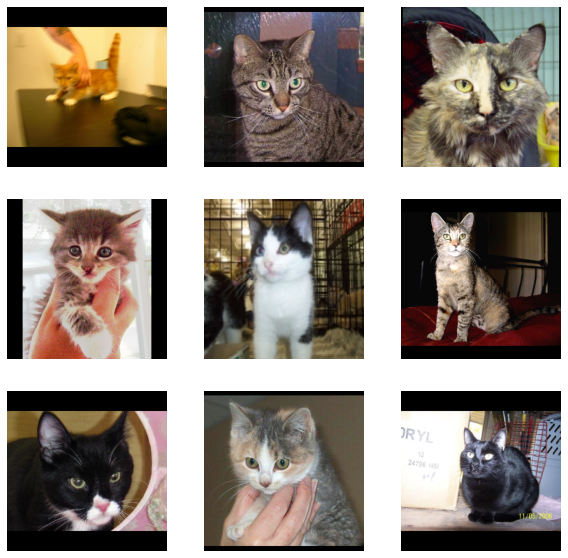

In [82]:
"""
Die Funktion norm_and_resize_with_padding() normalisiert das Bild zuerst und verändert die Bildauflösung dann so, dass die längere Seite des Bildes gleich der angegebenen 'size'
wird. Anschließend werden die fehlenden Rändern mit -1.0 (was gemäß unserer Norm für schwarz stellvertretend ist) aufgefüllt, sodass wir quadratische Bilder erhalten.
"""

def norm_and_resize_with_padding(img, size):
    size_max = np.max(img.shape)
    r = size/size_max
    img = cv2.resize(img, (int(round(img.shape[1]*r)), int(round(img.shape[0]*r))))
    img = normalise(img)
    offset_height = (size - img.shape[0])//2
    offset_width = (size - img.shape[1])//2
    canvas = np.float32(-np.ones((size,size,3)))
    canvas[offset_height : offset_height + img.shape[0], offset_width : offset_width + img.shape[1]] = img
    return canvas

"""
Da unsere plot_results()-Funktion mit uint8 in der Range [0, 255] arbeitet bietet es sich an eine Funktion zu schreiben, die Bilder von der Norm float32 [-1.0, +1.0] zur entsprechenden
uint8-Norm konvertiert.
"""
def to_uint8(img):
    return np.uint8((img + 1) * 127.5)

resized = [to_uint8(norm_and_resize_with_padding(img, 256)) for img in cats_imgs[:9]]
plot_results(resized)

Imported 11674 images.


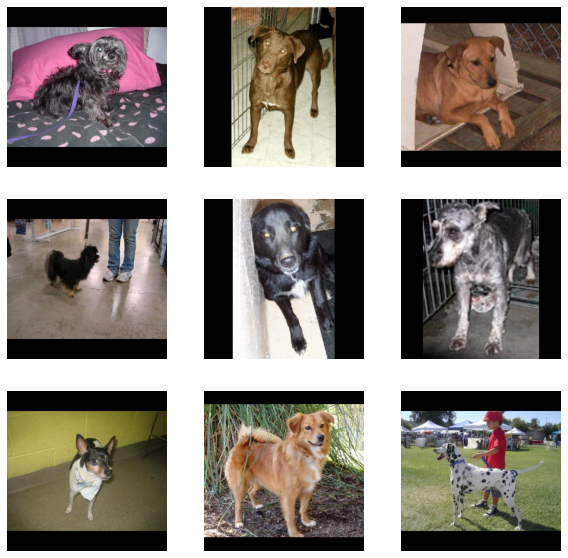

In [80]:
# 8000 Hundebilder laden
dogs_imgs = import_images_from_folder("INSERT PATH TO DOGS")
dogs_imgs = dogs_imgs[:8000]
# Probe visualisieren
resized = [to_uint8(norm_and_resize_with_padding(img, 256)) for img in dogs_imgs[:9]]
plot_results(resized)

In [17]:
# Kreieren wir die Labels für cats (=1) und dogs (=0). Zugegebenermaßen ist es angesichts des niedrigen RAMs nicht sonderlich klug 16000 Nullen und Einsen als float32 abszuspeichern.
# Alternativ könnte man im Trainingsloop das entsprechende Label 'on the fly', also genau dann wenn es im Code gebraucht wird, erstellen. Dafür müsste ich aber mehr coden.
# Das Finden einer entsprechenden Lösung, die diese Hardware nicht überfordert sei also auf spätere Lektionen vertagt bzw. der/m rigoros arbeitenden Studierenden überlassen.
cats_y = np.float32(np.ones(len(cats_imgs)))
dogs_y = np.float32(np.zeros(len(dogs_imgs)))

"""
Wir müssen nun alle Bilder resizen und anschließend normalisieren.
Die Bildgröße (=size) für unser Model sei 64x64px.
"""

size = 64
# 2 Python-Listen lassen sich einfach per '+' konkatenieren.
x_train = cats_imgs + dogs_imgs

# Normalisieren und resizen - das dauert ein paar Minuten...
print('preprocessing...')
x_train = [norm_and_resize_with_padding(img, size) for img in x_train]
# Konvertieren wir X nun zu einem npy-array (insofern unser RAM das verkraftet)
x_train = np.float32(x_train)

# Konkatenieren wir die Labels
y_train = np.concatenate((cats_y, dogs_y))
# Fügen eine Dimension hinzu, da unser Model shape (1,) und nicht shape () als label erwarten wird.
y_train = np.expand_dims(y_train, axis=-1)

preprocessing...


In [18]:
# Räumen wir mal RAM auf, indem wir alle mittlerweile nicht mehr benötigten Listen löschen
del cats_y
del dogs_y
del cats_imgs
del dogs_imgs

In [24]:
# Wir benötigen ein Testset, um zu schauen wie gut das trainierte Netz auf unbekannten Bildern performt.
# Mischen wir zunächst einmal das Datenset durch.
def unison_shuffled_copies(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

x_train, y_train = unison_shuffled_copies(x_train, y_train)

# Nehmen wir anschließend die letzten 2000 Examples als Testset.
x_test, y_test      = x_train[-2000:], y_train[-2000:]
x_train, y_train    = x_train[:-2000], y_train[:-2000]

In [20]:
# Bauen wir ein Model mit strided Convolutions.

def build_model(input_shape):
    img_input = Input(shape=input_shape)
    x = img_input

    ch = 1
    while int(x.shape[1]) > 4:
        x = Conv2D(32*ch, 3, strides=2, padding="same", activation='relu')(x)
        ch += 1

    x = Flatten()(x)
    pred = Dense(1, activation='sigmoid')(x)
    return Model(img_input, pred)


model = build_model((size,size,3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 96)          55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         110720    
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049  

In [28]:
# Lossfunction und Trainingsschritt
def binary_crossentropy(pred, true):
    loss = -(true * tf.math.log(pred+1e-7) + (1-true) * tf.math.log(1-pred+1e-7))
    loss = tf.reduce_mean(loss)
    return loss

def accuracy_of_batch(pred, true):
    batch_size = pred.shape[0]
    pred = tf.math.round(pred)
    is_equal_elementwise = tf.math.equal(pred, true)
    is_equal_elementwise = tf.cast(is_equal_elementwise, tf.float32)
    accuracy_percentage = tf.reduce_sum(is_equal_elementwise) / batch_size * 100
    return accuracy_percentage

@tf.function
def test_step(img, true, model):
    pred = model(img)
    accuracy = accuracy_of_batch(pred, true)
    return accuracy

# Flip batch with 0.5 probability
@tf.function
def flip_augmentation(batch):
    choice = tf.cast(tf.math.round(tf.random.uniform((), 0.0, 1.0)), tf.int32)
    if choice == 1:
        batch = tf.image.flip_left_right(batch)
    return batch

@tf.function
def train_step(img, true, model, optimizer):
    with tf.GradientTape() as tape:
        img = flip_augmentation(img)
        pred = model(img)
        loss = binary_crossentropy(pred, true)
    gradients = tape.gradient(target=loss, sources=model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss

def get_tf_dataset(batch_size, x_train, y_train):
    x_train, y_train = unison_shuffled_copies(x_train, y_train)
    x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
    y_train = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size)
    return zip(x_train, y_train)

In [29]:
"""
Im letzten Notebook haben wir die tensorflow-dataset-Objects folgendermaßen generiert:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
Dabei wird eine Kopie von jedem Beispiel angefertigt, sodass unser RAM möglicherweise vollläuft.
Unser Datenset ist dieses mal schon recht groß, daher brauchen wir einen Workaround.

Tensorflow bietet die Möglichkeit ein Tensorflow-Dataset aus einem python-Generator zu erstellen.
Das ist eine Funktion, die in einem Loop Objekte per Keyword "yield" ausgibt.
Dadurch entstehen keine Kopien des Datensets im RAM. Wir bauen also eine solche Funktion, die wir dann an
tf.data.Dataset.from_generator() übergeben können. Die Funktion braucht außerdem ein paar zusätzliche
Argumente (wie Datentyp und Shape der ausgegebenen Trainingsexamples), um zurechtzukommen.
Solcherlei Umstände ergeben sich aus dem Design von Tensorflow und muss von uns wohl oder übel akzeptiert werden, wenn wir das Framework benutzen wollen.
"""

def get_tf_dataset(batch_size, x_train, y_train):
    x_train, y_train = unison_shuffled_copies(x_train, y_train)

    # Generator-Funktion
    def generator():
        for x, y in zip(x_train, y_train):
            yield x, y

    tf_dataset = tf.data.Dataset.from_generator(
        generator = generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=((size, size, 3), (1,))
    )
    
    tf_dataset = tf_dataset.batch(batch_size)
    return tf_dataset

In [ ]:
# Adam-Optimizer
optimizer = Adam(learning_rate=0.0001)

batch_size = 64
epochs = 100

mean_epoch_losses = []
mean_epoch_accuracies = []

for epoch in range(epochs):
    print('epoch '+str(epoch))
    train_dataset = get_tf_dataset(batch_size, x_train, y_train)
    test_dataset = get_tf_dataset(batch_size, x_test, y_test)

    # train
    epoch_losses = []
    pb = Progbar(x_train.shape[0], stateful_metrics=['loss'])
    for image, true in train_dataset:
        loss_tensor = train_step(image, true, model, optimizer)
        pb.add(batch_size, values=[('loss', loss_tensor)])
        epoch_losses.append(loss_tensor.numpy())

    mean_epoch_loss = np.mean(epoch_losses)
    mean_epoch_losses.append(mean_epoch_loss)

    # test
    epoch_accuracies = []
    for image, true in test_dataset:
        accuracy_tensor = test_step(image, true, model)
        epoch_accuracies.append(accuracy_tensor.numpy())
    mean_epoch_accuracy = np.mean(epoch_accuracies)
    mean_epoch_accuracies.append(mean_epoch_accuracy)

    print('loss: ' + str(mean_epoch_loss) + ' accuracy: ' + str(mean_epoch_accuracy)+'%')

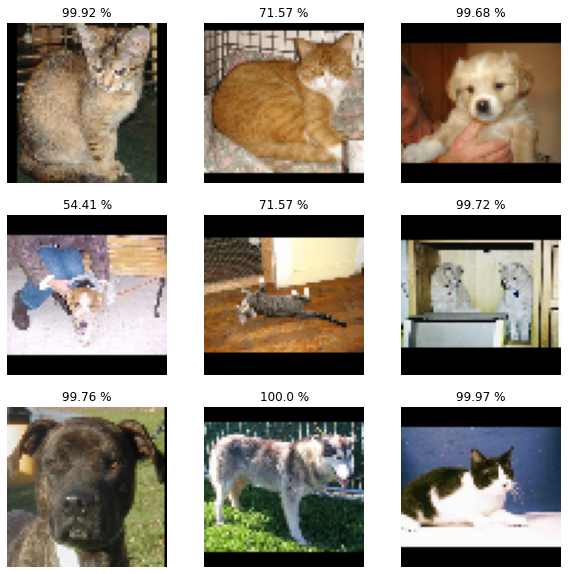

In [71]:
# Ergebnisse visualisieren
imgs, percentages = [], []
for image, label in zip(x_test[:9], y_test[:9]):
    image = np.expand_dims(image, axis=0)
    pred = model(image)
    imgs.append(to_uint8(image[0]))
    percentages.append(np.round(100-(np.abs(label - pred)*100)[0][0], 2))
percentages = [str(x)+' %' for x in percentages]

plot_results(imgs, percentages)